In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, stddev, min, max
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark
spark = SparkSession.builder \
    .appName("Detailed CSV Data Analysis") \
    .getOrCreate()

# Display Spark version
print("Spark Version:", spark.version)


Spark Version: 3.5.6


In [3]:
# Load the CSV file into a Spark DataFrame
file_path = "RainfallDataset_f.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show basic info
df.printSchema()
df.show(5)


root
 |-- Date With Month wise Rainfall in mm: string (nullable = true)
 |-- Dharashiv: double (nullable = true)
 |-- Tuljapur: double (nullable = true)
 |-- Paranda: double (nullable = true)
 |-- Bhum: double (nullable = true)
 |-- Kalamb: double (nullable = true)
 |-- Umarga: double (nullable = true)
 |-- Lohara: double (nullable = true)
 |-- Washi: double (nullable = true)
 |-- District-Dharashiv: double (nullable = true)

+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|Date With Month wise Rainfall in mm|Dharashiv|Tuljapur|Paranda|Bhum|Kalamb|Umarga|Lohara|Washi|District-Dharashiv|
+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|                         01/06/2025|      0.0|     0.0|    0.0| 0.0|   0.0|   0.0|   0.0|  0.0|               0.0|
|                         02/06/2025|      4.1|     0.7|    2.8| 1.9|   0.4|   0.0|   0.0|  0.4|          

In [4]:
# Total rows and columns
print(f"Total Rows: {df.count()}")
print(f"Total Columns: {len(df.columns)}")

# Column names
print("Columns:", df.columns)

# Data types
df.dtypes


Total Rows: 116
Total Columns: 10
Columns: ['Date With Month wise Rainfall in mm', 'Dharashiv', 'Tuljapur', 'Paranda', 'Bhum', 'Kalamb', 'Umarga', 'Lohara', 'Washi', 'District-Dharashiv']


[('Date With Month wise Rainfall in mm', 'string'),
 ('Dharashiv', 'double'),
 ('Tuljapur', 'double'),
 ('Paranda', 'double'),
 ('Bhum', 'double'),
 ('Kalamb', 'double'),
 ('Umarga', 'double'),
 ('Lohara', 'double'),
 ('Washi', 'double'),
 ('District-Dharashiv', 'double')]

+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|Date With Month wise Rainfall in mm|Dharashiv|Tuljapur|Paranda|Bhum|Kalamb|Umarga|Lohara|Washi|District-Dharashiv|
+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|                                  0|        0|       0|      0|   0|     0|     0|     0|    0|                 0|
+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+



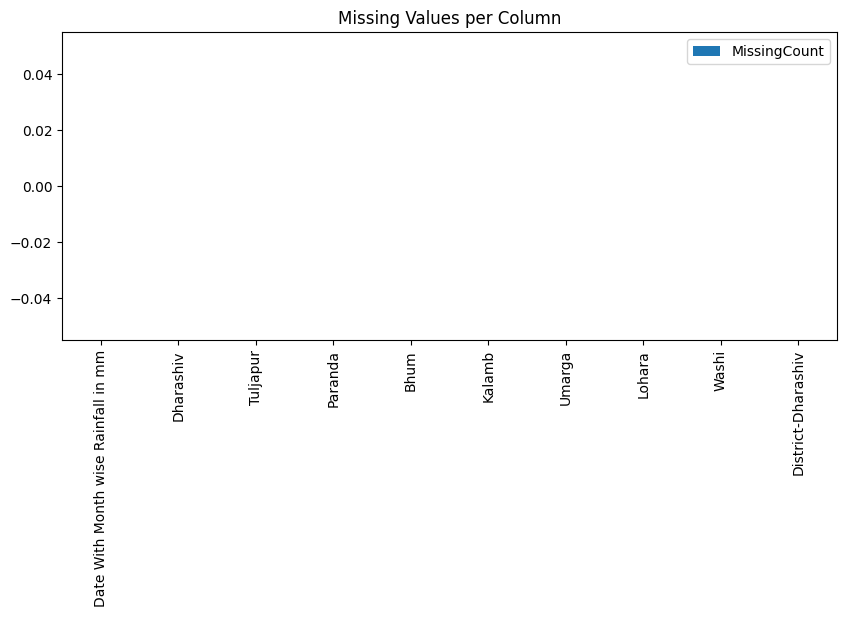

In [5]:
# Calculate missing (null/NaN) counts per column
missing_df = df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns
])
missing_df.show()

# Visualize missing data
missing_pd = missing_df.toPandas().T
missing_pd.columns = ["MissingCount"]
missing_pd.plot(kind='bar', figsize=(10,4), title="Missing Values per Column")
plt.show()


In [6]:
df.describe().show(truncate=False)


+-------+-----------------------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|Date With Month wise Rainfall in mm|Dharashiv         |Tuljapur         |Paranda           |Bhum             |Kalamb            |Umarga            |Lohara            |Washi            |District-Dharashiv|
+-------+-----------------------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|count  |116                                |116               |116              |116               |116              |116               |116               |116               |116              |116               |
|mean   |NULL                               |6.30344827586207  |7.397413793103446|6.118103448275861 |7.495689655172414|7.8241379310344845|7.4732

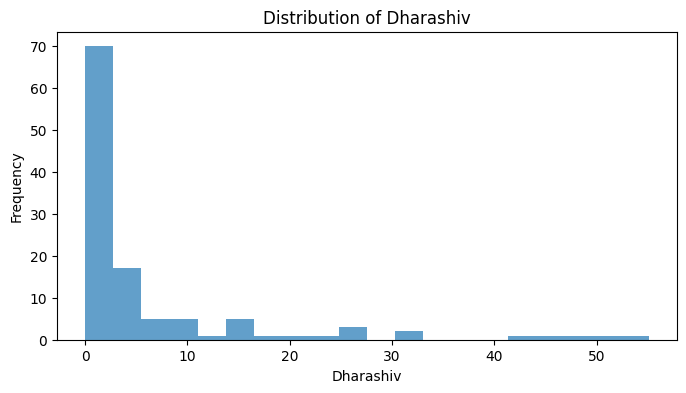

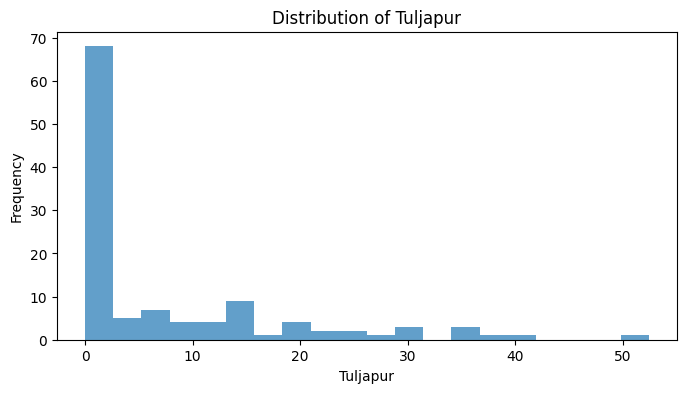

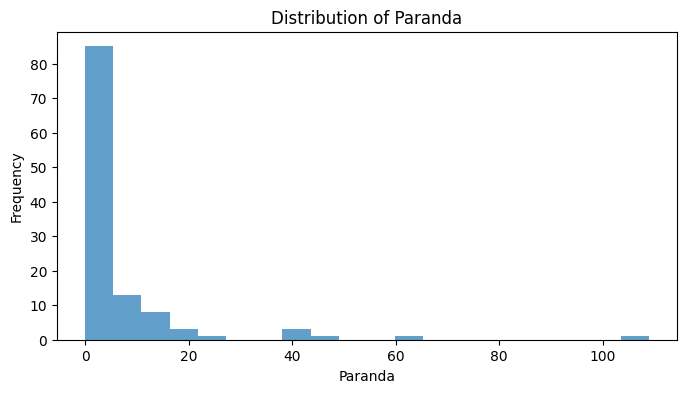

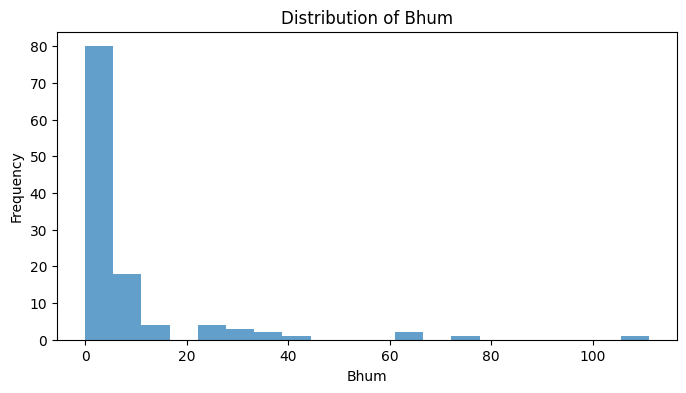

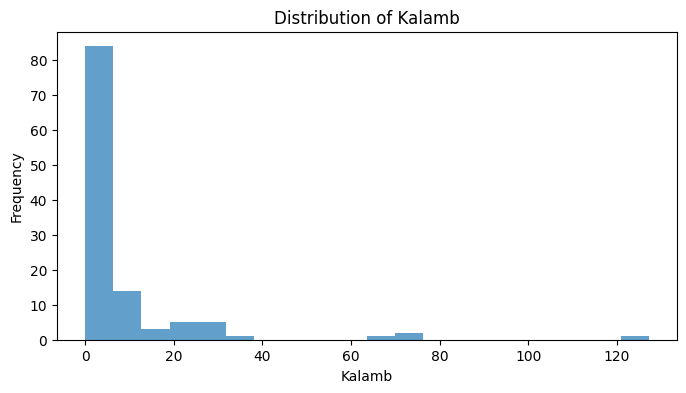

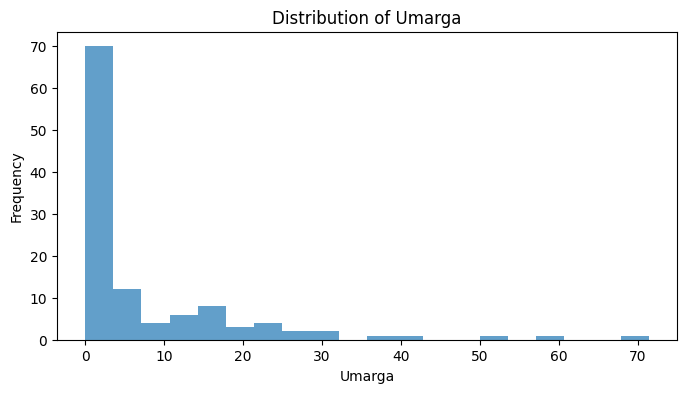

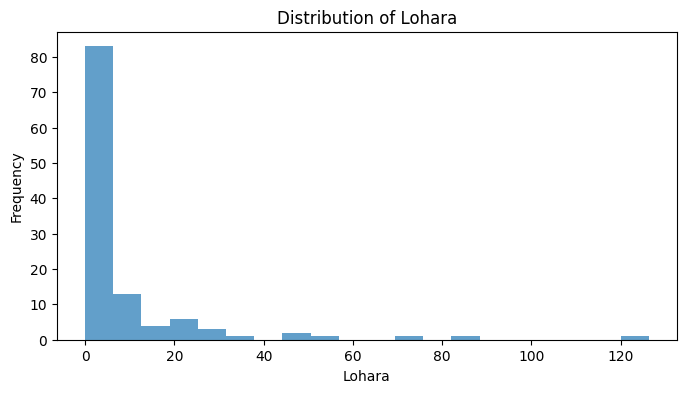

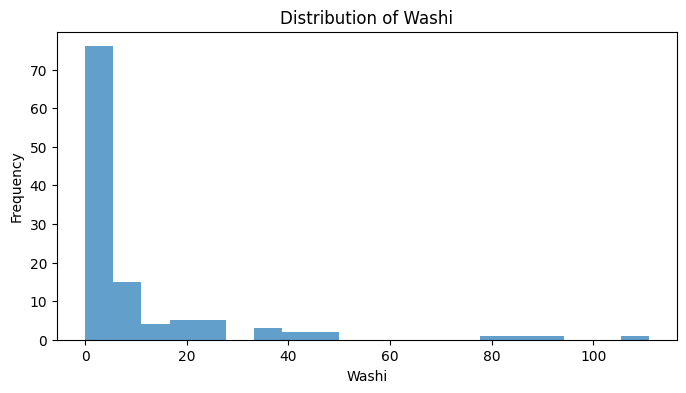

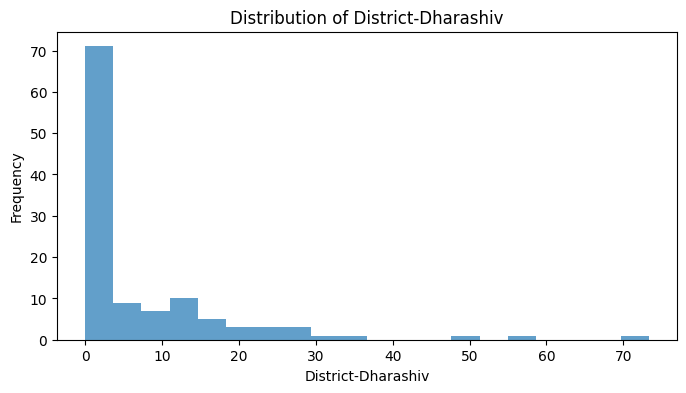

In [7]:
# Identify numeric columns
numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float', 'bigint')]

for col_name in numeric_cols:
    pdf = df.select(col_name).dropna().toPandas()
    plt.figure(figsize=(8,4))
    plt.hist(pdf[col_name], bins=20, alpha=0.7)
    plt.title(f"Distribution of {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()


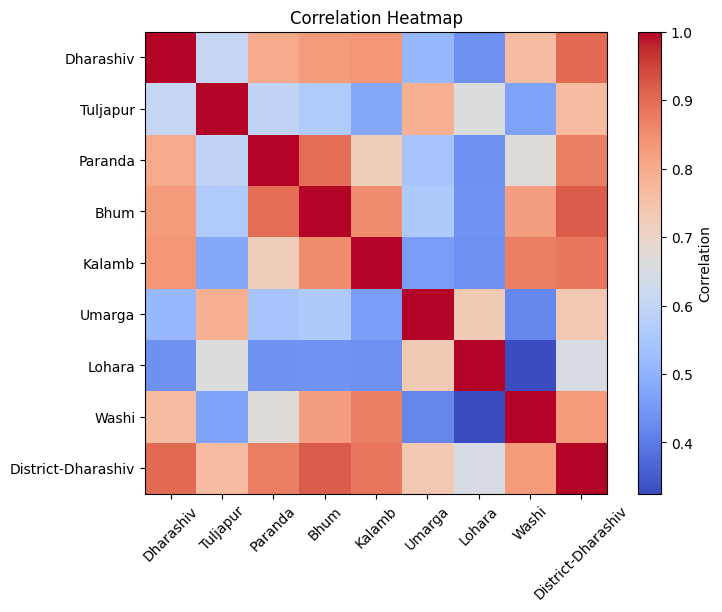

In [8]:
if len(numeric_cols) > 1:
    pdf_corr = df.select(numeric_cols).toPandas().corr()
    plt.figure(figsize=(8,6))
    plt.imshow(pdf_corr, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(pdf_corr)), pdf_corr.columns, rotation=45)
    plt.yticks(range(len(pdf_corr)), pdf_corr.columns)
    plt.title("Correlation Heatmap")
    plt.show()


Top Categories in Date With Month wise Rainfall in mm:
+-----------------------------------+-----+
|Date With Month wise Rainfall in mm|count|
+-----------------------------------+-----+
|                         24/06/2025|    1|
|                         30/08/2025|    1|
|                         10/06/2025|    1|
|                         21/07/2025|    1|
|                         08/06/2025|    1|
+-----------------------------------+-----+
only showing top 5 rows



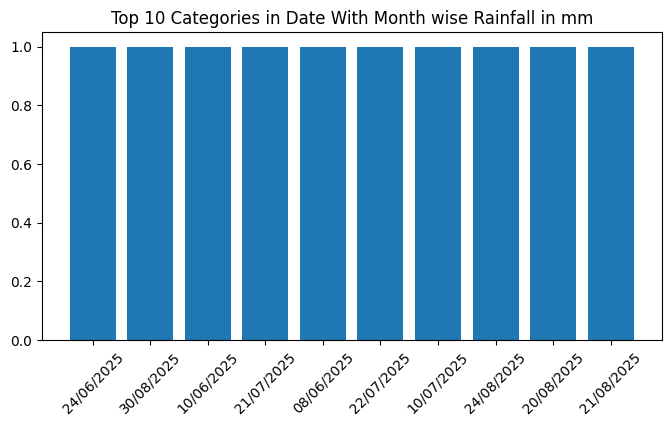

In [9]:
# Identify categorical columns
categorical_cols = [c for c, t in df.dtypes if t == 'string']

for c in categorical_cols:
    print(f"Top Categories in {c}:")
    df.groupBy(c).count().orderBy("count", ascending=False).show(5)

    # Plot top 10
    top_pd = df.groupBy(c).count().orderBy("count", ascending=False).limit(10).toPandas()
    plt.figure(figsize=(8,4))
    plt.bar(top_pd[c], top_pd['count'])
    plt.title(f"Top 10 Categories in {c}")
    plt.xticks(rotation=45)
    plt.show()


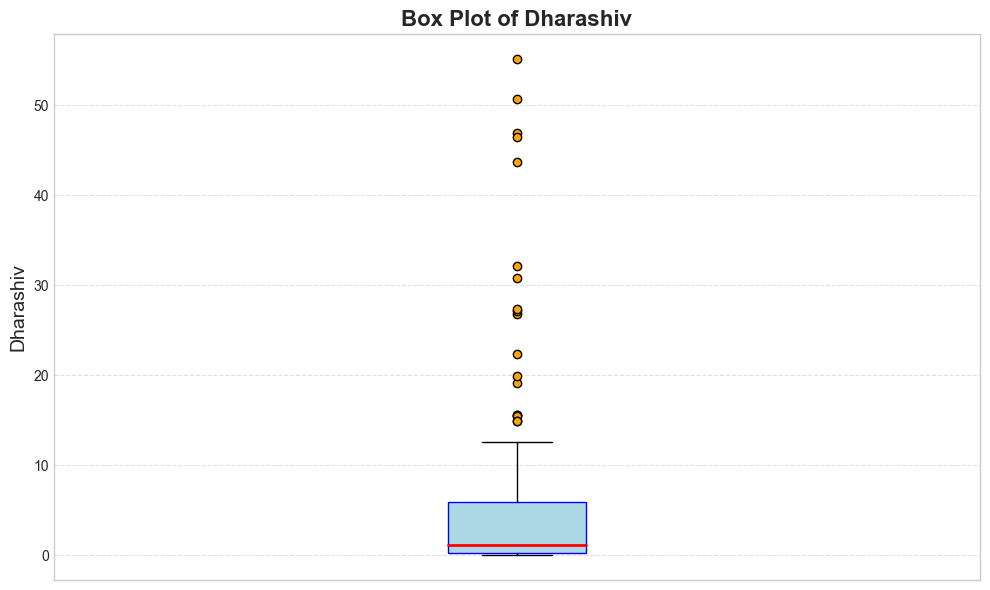

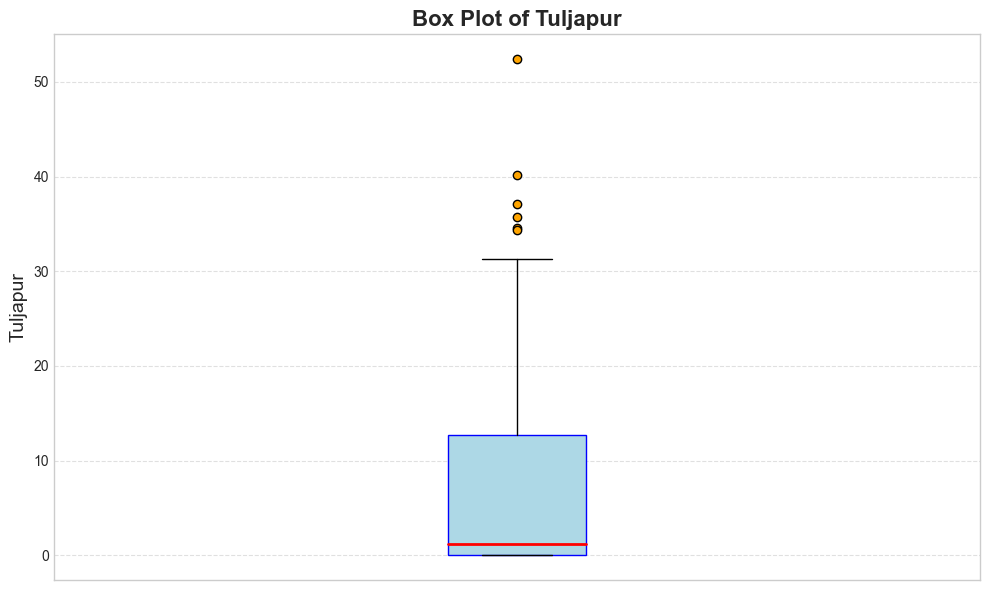

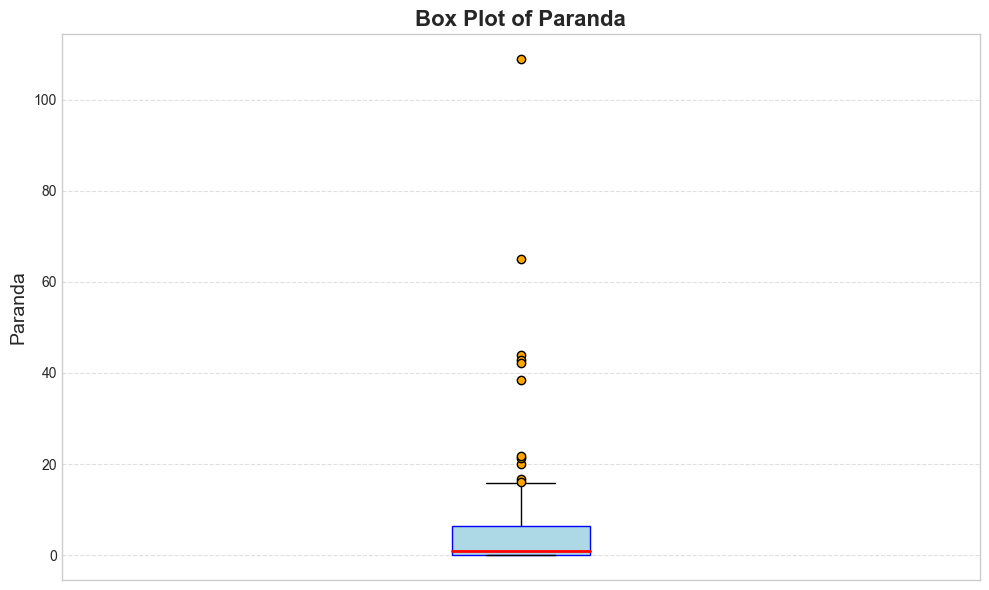

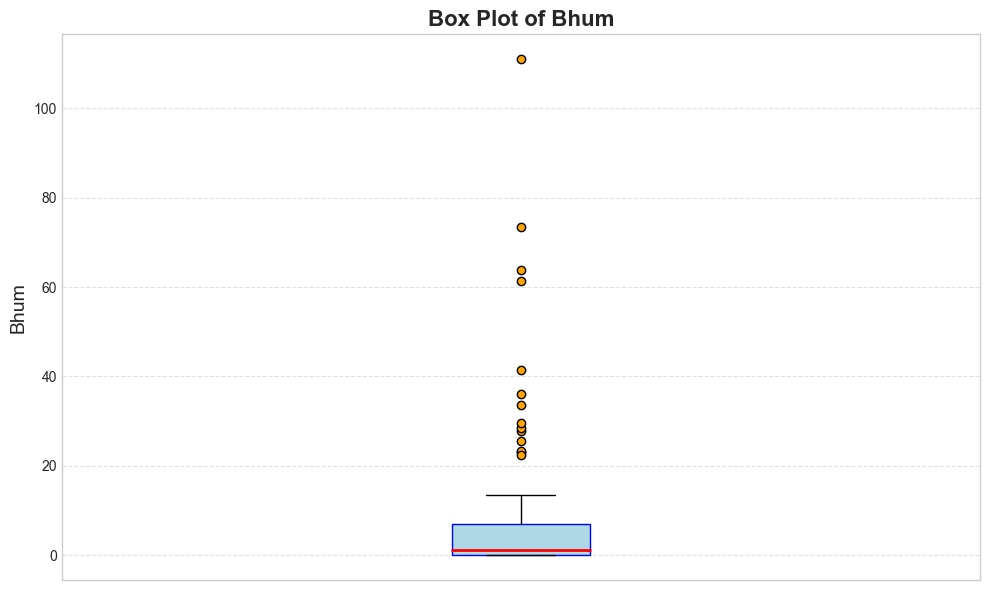

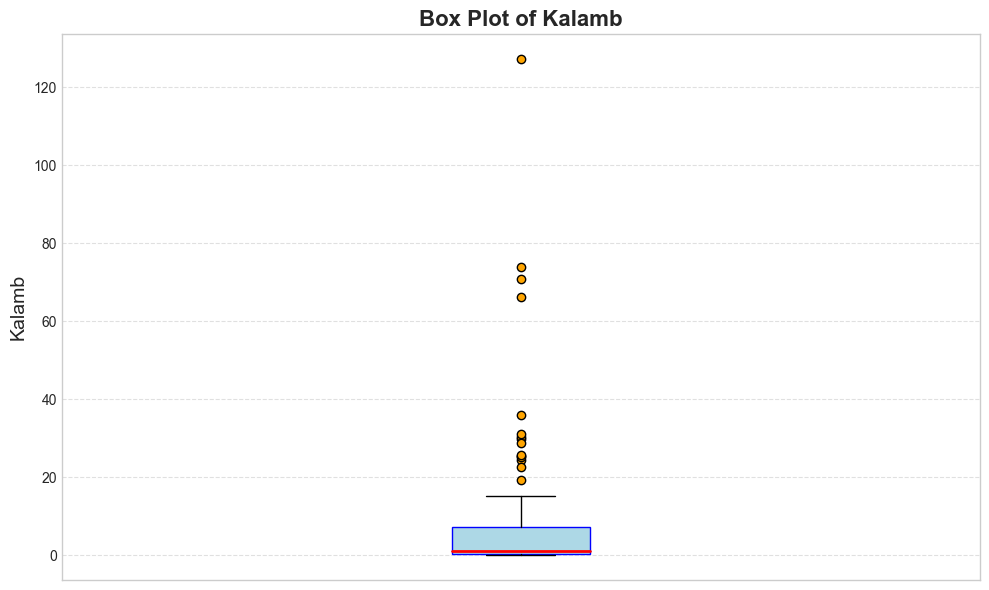

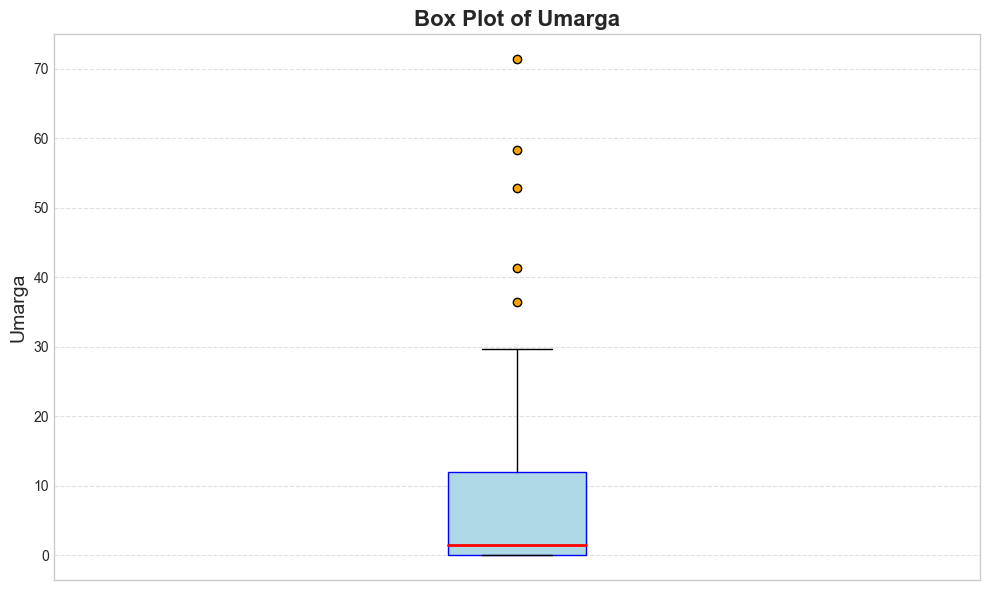

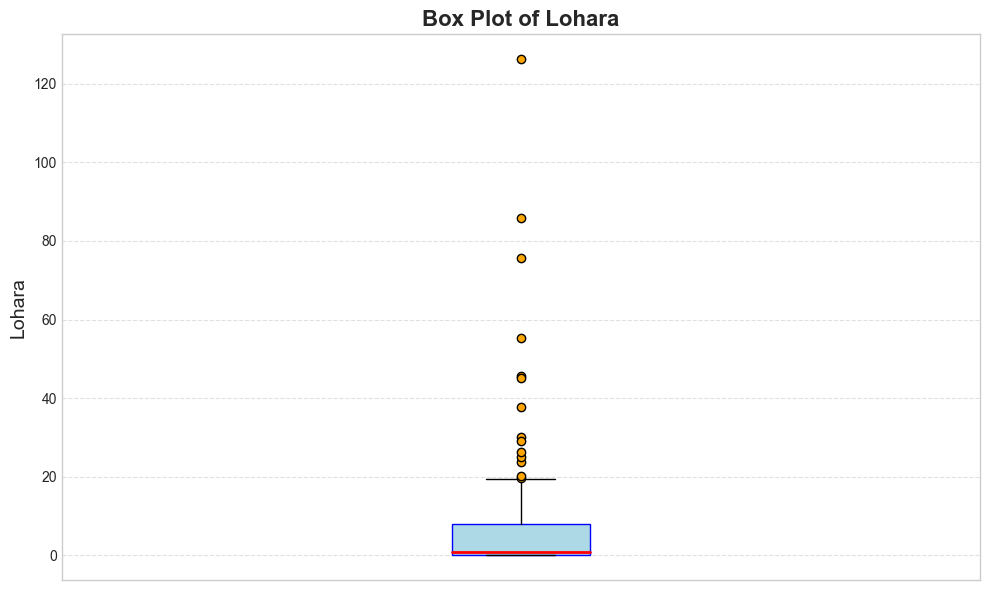

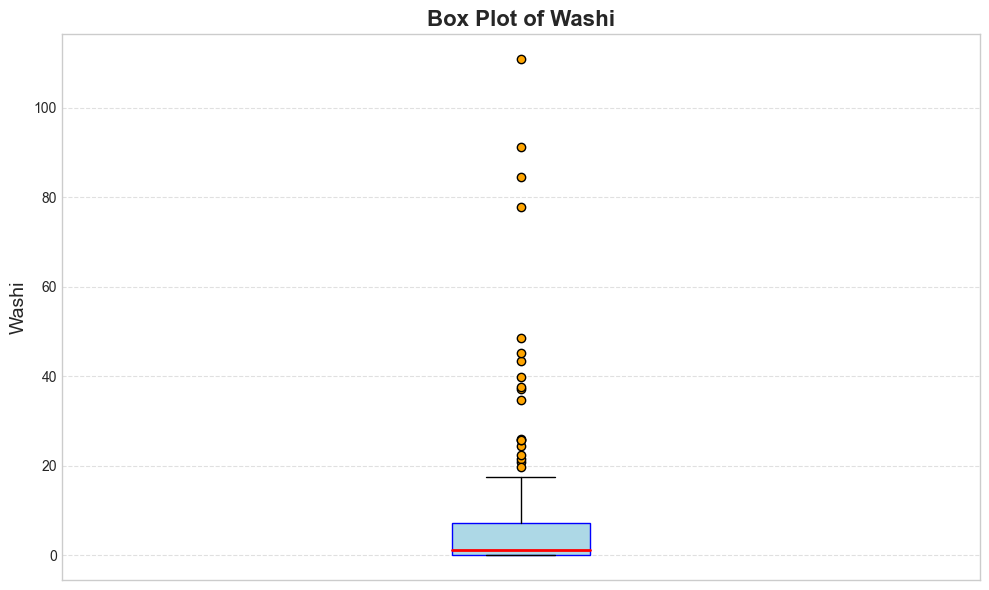

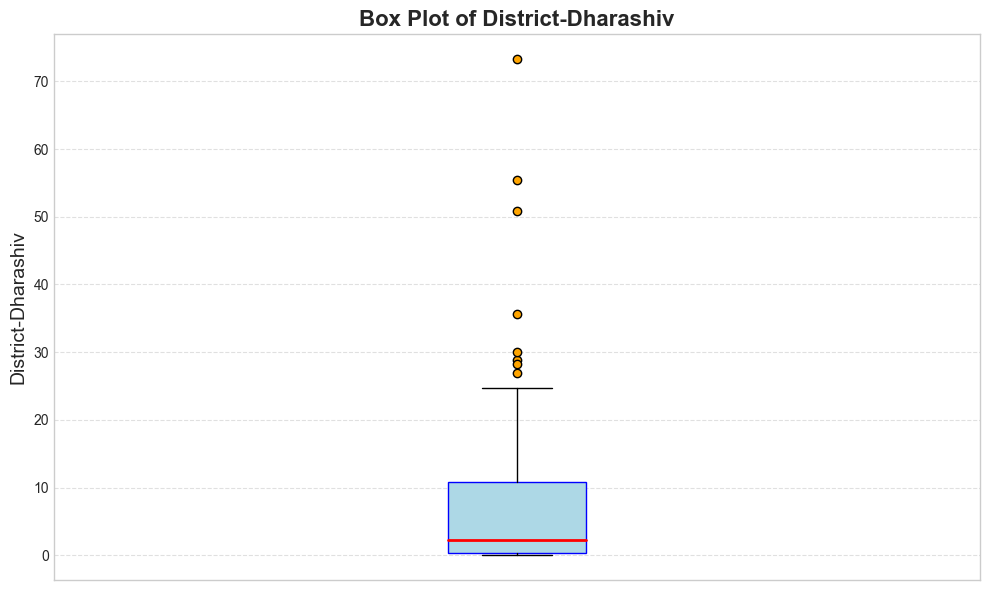

In [13]:
import matplotlib.pyplot as plt

# Set global plot style
plt.style.use("seaborn-v0_8-whitegrid")

# Larger figure and better readability
for col_name in numeric_cols:
    pdf = df.select(col_name).dropna().toPandas()

    plt.figure(figsize=(10, 6))  # 🔹 Increased figure size
    plt.boxplot(pdf[col_name], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='orange', marker='o', markersize=6, linestyle='none'))
    
    plt.title(f"Box Plot of {col_name}", fontsize=16, fontweight='bold')
    plt.ylabel(col_name, fontsize=14)
    plt.xticks([])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


C:\Users\anush\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


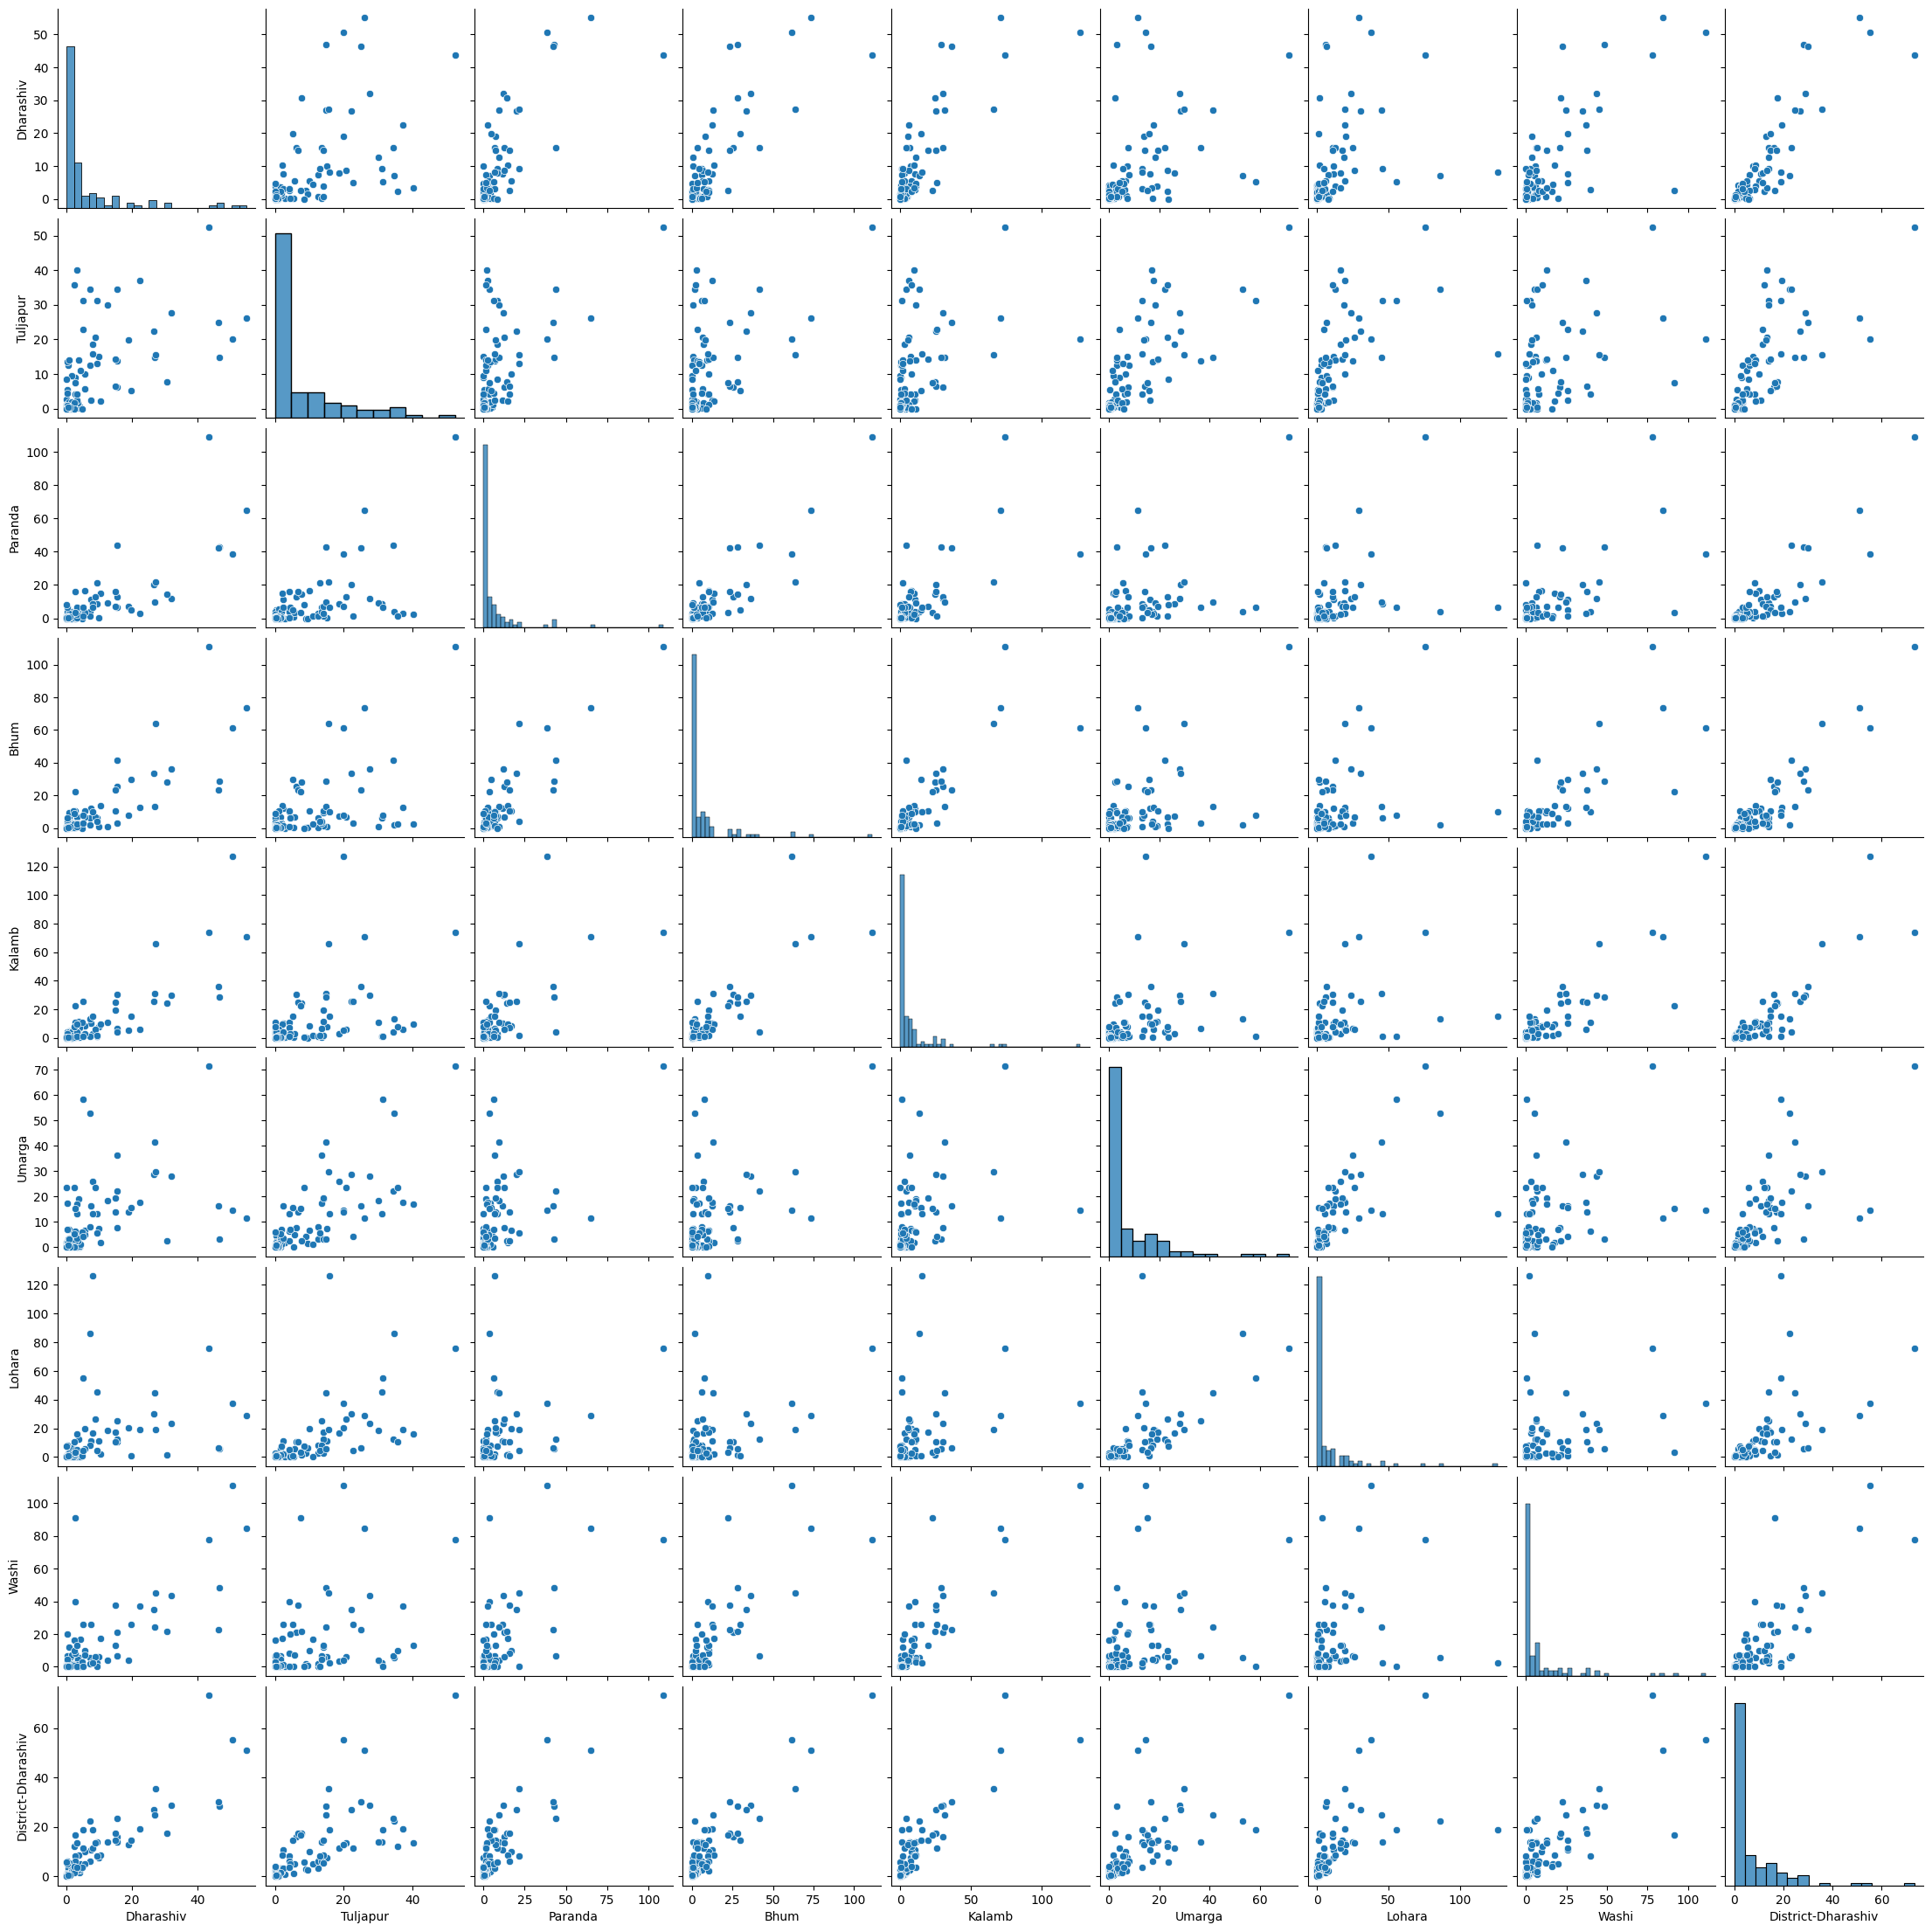

In [11]:
import seaborn as sns

if len(numeric_cols) >= 2:
    pdf = df.select(numeric_cols).dropna().toPandas()
    sns.pairplot(pdf)
    plt.show()


In [12]:
# Save cleaned version (drop missing rows)
df_clean = df.dropna()
df_clean.write.csv("cleaned_output", header=True, mode="overwrite")
print("✅ Cleaned data saved as 'cleaned_output' folder.")


✅ Cleaned data saved as 'cleaned_output' folder.


In [14]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col


In [15]:
# Identify numeric columns for ML
numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float', 'bigint')]

# If a categorical target column exists, define it here manually
# Example: target_col = "Species" or "Label"
# If none, leave as None
target_col = None   # 👈 Set your target column name if you have one

print("Numeric columns used for features:", numeric_cols)

# Assemble numeric features into a single vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

df_ml = assembler.transform(df).select(*([target_col] if target_col else []), "features")
df_ml.show(5, truncate=False)


Numeric columns used for features: ['Dharashiv', 'Tuljapur', 'Paranda', 'Bhum', 'Kalamb', 'Umarga', 'Lohara', 'Washi', 'District-Dharashiv']
+----------------------------------------+
|features                                |
+----------------------------------------+
|(9,[],[])                               |
|[4.1,0.7,2.8,1.9,0.4,0.0,0.0,0.4,1.5]   |
|(9,[],[])                               |
|(9,[4,5,8],[0.4,0.4,0.1])               |
|[10.0,15.1,0.1,0.6,7.5,7.4,11.4,5.9,7.7]|
+----------------------------------------+
only showing top 5 rows



✅ Silhouette score = 0.7002
Cluster 0 Center: [1.47093023 2.36511628 1.82325581 1.85930233 1.82674419 2.21627907
 1.68023256 2.8127907  1.95697674]
Cluster 1 Center: [49.83333333 32.83333333 70.8        81.9        90.56666667 32.53333333
 47.5        91.13333333 59.86666667]
Cluster 2 Center: [16.85925926 20.6        12.61111111 17.18148148 17.73333333 21.43333333
 24.79259259 21.54444444 18.58518519]


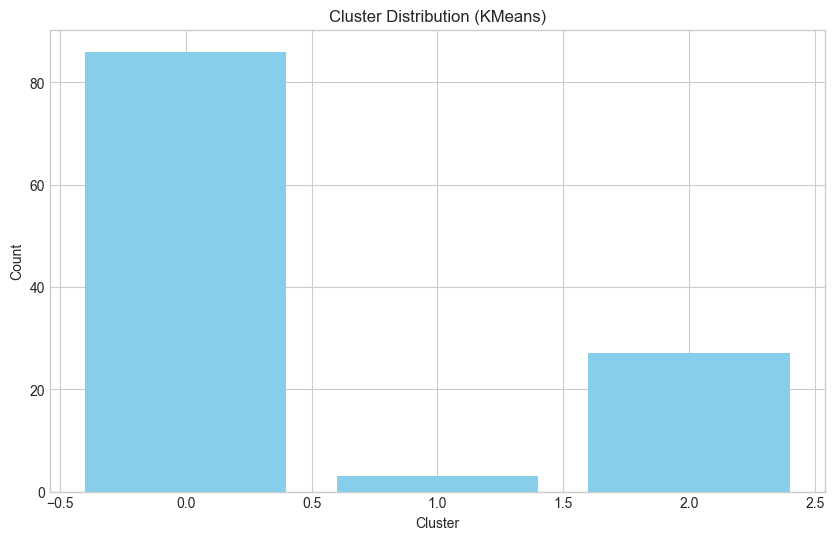

In [17]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Run KMeans on numeric data
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="prediction")
model_kmeans = kmeans.fit(df_ml)

# Make predictions
preds_kmeans = model_kmeans.transform(df_ml)

# Evaluate clustering by Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette = evaluator.evaluate(preds_kmeans)
print(f"✅ Silhouette score = {silhouette:.4f}")

# Show cluster centers
centers = model_kmeans.clusterCenters()
for i, c in enumerate(centers):
    print(f"Cluster {i} Center: {c}")

# Plot cluster distribution
cluster_pd = preds_kmeans.groupBy("prediction").count().orderBy("prediction").toPandas()
plt.figure(figsize=(10,6))
plt.bar(cluster_pd["prediction"], cluster_pd["count"], color="skyblue")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution (KMeans)")
plt.show()


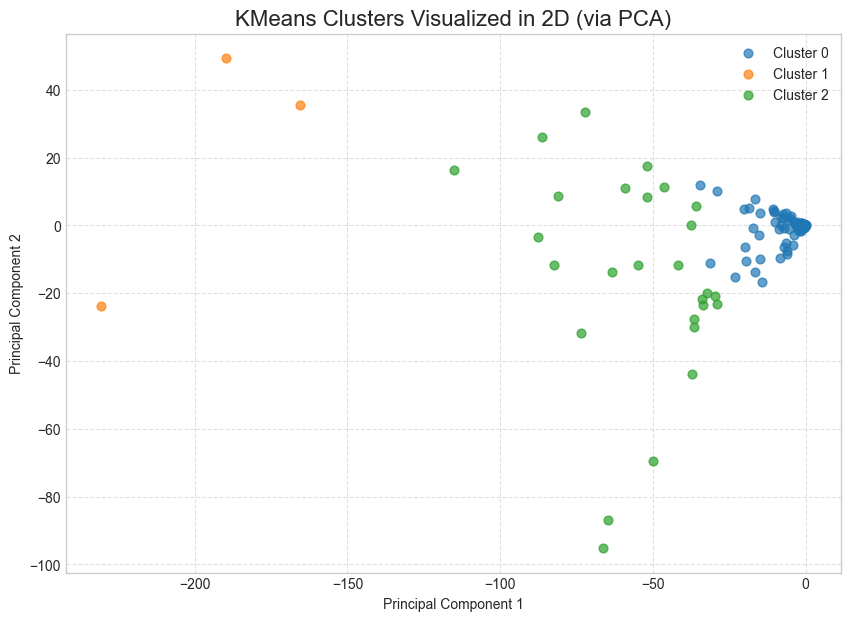

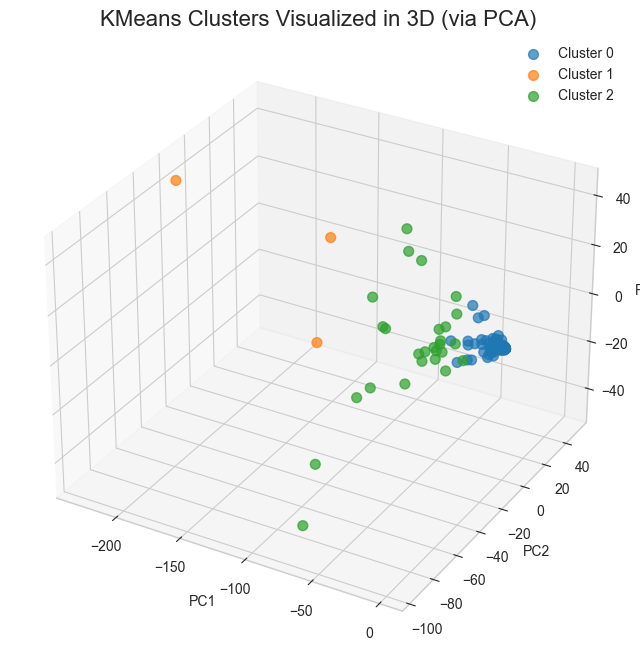

In [19]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---- PCA for Dimensionality Reduction ----
# Reduce the high-dimensional "features" vector to 3 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(preds_kmeans)
df_pca = pca_model.transform(preds_kmeans)

# Select only PCA components and cluster labels
pca_pd = df_pca.select("pcaFeatures", "prediction").toPandas()

# Extract PCA components into separate columns
pca_pd[["PC1", "PC2", "PC3"]] = pca_pd["pcaFeatures"].apply(lambda x: pd.Series(x))
pca_pd.drop(columns=["pcaFeatures"], inplace=True)

# ---- 2D PCA Plot ----
plt.figure(figsize=(10,7))
for cluster_id in sorted(pca_pd["prediction"].unique()):
    cluster_points = pca_pd[pca_pd["prediction"] == cluster_id]
    plt.scatter(cluster_points["PC1"], cluster_points["PC2"], label=f"Cluster {cluster_id}", s=40, alpha=0.7)

plt.title("KMeans Clusters Visualized in 2D (via PCA)", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ---- 3D PCA Plot ----
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in sorted(pca_pd["prediction"].unique()):
    cluster_points = pca_pd[pca_pd["prediction"] == cluster_id]
    ax.scatter(cluster_points["PC1"], cluster_points["PC2"], cluster_points["PC3"], label=f"Cluster {cluster_id}", s=50, alpha=0.7)

ax.set_title("KMeans Clusters Visualized in 3D (via PCA)", fontsize=16)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()


In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, trim, lower, when, isnan, count, lit, to_date,
    dayofweek, dayofmonth, month, year
)

# -----------------------------
# 1️⃣ Initialize Spark
# -----------------------------
spark = SparkSession.builder.appName("Cleaning_FeatureEngineering_DayColumns").getOrCreate()

# -----------------------------
# 2️⃣ Load CSV
# -----------------------------
df = spark.read.csv("RainfallDataset_f.csv", header=True, inferSchema=True)
print("✅ Data Loaded")
df.printSchema()

# -----------------------------
# 3️⃣ Basic Cleaning
# -----------------------------
# Trim whitespace and lowercase string columns
for c, t in df.dtypes:
    if t == "string":
        df = df.withColumn(c, trim(lower(col(c))))

# Replace common missing values with NULL
df = df.replace(["", "na", "n/a", "none", "null", "?"], None)

# Drop duplicate rows
df = df.dropDuplicates()

# -----------------------------
# 4️⃣ Handle Missing Values
# -----------------------------
# Count missing values
missing_summary = df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns])
missing_summary.show(truncate=False)

# Fill numeric columns with mean
numeric_cols = [c for c, t in df.dtypes if t in ("int", "double", "float", "bigint")]
for colname in numeric_cols:
    mean_val = df.select(col(colname)).na.drop().groupBy().avg().first()[0]
    if mean_val is not None:
        df = df.fillna({colname: mean_val})

# Fill string columns with mode
string_cols = [c for c, t in df.dtypes if t == "string"]
for colname in string_cols:
    mode_val = df.groupBy(colname).count().orderBy("count", ascending=False).first()
    if mode_val:
        df = df.fillna({colname: mode_val[0]})

# -----------------------------
# 5️⃣ Day Column Feature Engineering
# -----------------------------
# Use the correct date column name with spaces
date_col = "`Date With Month wise Rainfall in mm`"

# Convert to proper date type (adjust format if needed)
df = df.withColumn("Day_date", to_date(col(date_col), "dd/MM/yyyy"))

# Extract day of week, day of month, month, year
df = df.withColumn("Day_of_week", dayofweek(col("Day_date")))  # 1=Sunday, 7=Saturday
df = df.withColumn("Day_of_month", dayofmonth(col("Day_date")))
df = df.withColumn("Month", month(col("Day_date")))
df = df.withColumn("Year", year(col("Day_date")))

# Weekend indicator
df = df.withColumn("Is_weekend", when(col("Day_of_week").isin([1,7]), 1).otherwise(0))

# Season column
df = df.withColumn("Season", 
                   when(col("Month").isin([12,1,2]), "Winter")
                   .when(col("Month").isin([3,4,5]), "Spring")
                   .when(col("Month").isin([6,7,8]), "Summer")
                   .otherwise("Autumn"))

# -----------------------------
# 6️⃣ Show Sample
# -----------------------------
df.select(date_col, "Day_date", "Day_of_week", "Day_of_month", "Month", "Year", "Is_weekend", "Season").show(10, truncate=False)


✅ Data Loaded
root
 |-- Date With Month wise Rainfall in mm: string (nullable = true)
 |-- Dharashiv: double (nullable = true)
 |-- Tuljapur: double (nullable = true)
 |-- Paranda: double (nullable = true)
 |-- Bhum: double (nullable = true)
 |-- Kalamb: double (nullable = true)
 |-- Umarga: double (nullable = true)
 |-- Lohara: double (nullable = true)
 |-- Washi: double (nullable = true)
 |-- District-Dharashiv: double (nullable = true)

+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|Date With Month wise Rainfall in mm|Dharashiv|Tuljapur|Paranda|Bhum|Kalamb|Umarga|Lohara|Washi|District-Dharashiv|
+-----------------------------------+---------+--------+-------+----+------+------+------+-----+------------------+
|0                                  |0        |0       |0      |0   |0     |0     |0     |0    |0                 |
+-----------------------------------+---------+--------+-------+----+------+------+------+--

Silhouette Score (KMeans): 0.5363
KMeans Cluster Distribution:
   prediction  count
0           0     87
1           1     23
2           2      6
⚠️ BisectingKMeans formed only 1 cluster. Silhouette cannot be computed.
Silhouette Score (GMM): 0.3202


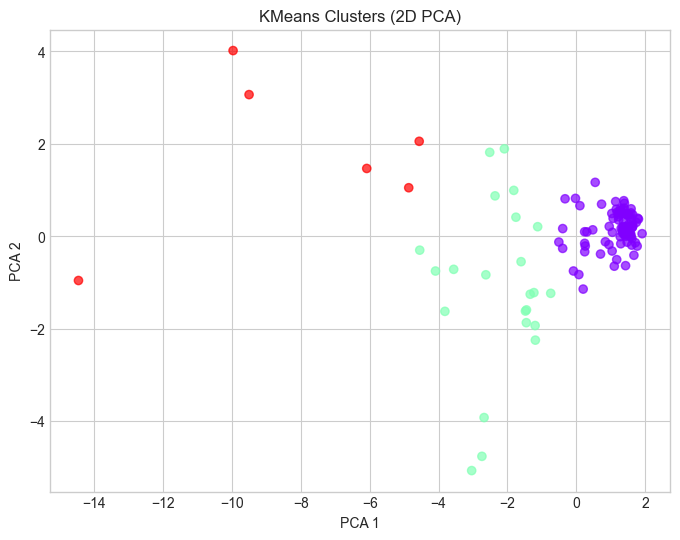

In [37]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1️⃣ Select numeric features
# -----------------------------
numeric_cols = [c for c, t in df.dtypes if t in ("int", "double", "float", "bigint")]

# Assemble features
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_unscaled")
df_vector = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
df_scaled = scaler.fit(df_vector).transform(df_vector)

# Clustering evaluator
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")

# -----------------------------
# 2️⃣ KMeans Clustering
# -----------------------------
kmeans = KMeans(k=3, seed=42, featuresCol="features")
model_kmeans = kmeans.fit(df_scaled)
preds_kmeans = model_kmeans.transform(df_scaled)

silhouette_kmeans = evaluator.evaluate(preds_kmeans)
print(f"Silhouette Score (KMeans): {silhouette_kmeans:.4f}")

# Cluster distribution
cluster_dist_kmeans = preds_kmeans.groupBy("prediction").count().orderBy("prediction").toPandas()
print("KMeans Cluster Distribution:")
print(cluster_dist_kmeans)

# -----------------------------
# 3️⃣ Bisecting KMeans Clustering
# -----------------------------
bkm = BisectingKMeans(k=3, seed=42, featuresCol="features")
model_bkm = bkm.fit(df_scaled)
preds_bkm = model_bkm.transform(df_scaled)

# Check number of clusters actually formed
num_clusters_bkm = preds_bkm.select("prediction").distinct().count()
if num_clusters_bkm > 1:
    silhouette_bkm = evaluator.evaluate(preds_bkm)
    print(f"Silhouette Score (Bisecting KMeans): {silhouette_bkm:.4f}")
else:
    print(f"⚠️ BisectingKMeans formed only {num_clusters_bkm} cluster. Silhouette cannot be computed.")

# -----------------------------
# 4️⃣ Gaussian Mixture Model Clustering
# -----------------------------
gmm = GaussianMixture(k=3, seed=42, featuresCol="features")
model_gmm = gmm.fit(df_scaled)
preds_gmm = model_gmm.transform(df_scaled)

num_clusters_gmm = preds_gmm.select("prediction").distinct().count()
if num_clusters_gmm > 1:
    silhouette_gmm = evaluator.evaluate(preds_gmm)
    print(f"Silhouette Score (GMM): {silhouette_gmm:.4f}")
else:
    print(f"⚠️ GMM formed only {num_clusters_gmm} cluster. Silhouette cannot be computed.")

# -----------------------------
# 5️⃣ PCA for 2D visualization of KMeans
# -----------------------------
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(preds_kmeans)
pca_result = pca_model.transform(preds_kmeans)

pdf = pca_result.select("pcaFeatures", "prediction").toPandas()
pdf["x"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))

plt.figure(figsize=(8,6))
plt.scatter(pdf["x"], pdf["y"], c=pdf["prediction"], cmap="rainbow", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters (2D PCA)")
plt.show()
